In [1]:
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
# draw the tensor computational graph using graphviz
from torchviz import make_dot

def draw_dot(tensor):
    dot = make_dot(tensor)
    dot.format = 'png'
    dot.render('tmp')
    dot.view()

In [3]:
class F:
    @staticmethod
    def B(x, k, i, t):
       if k == 0:
          return 1.0 if t[i] <= x < t[i+1] else 0.0
       
       if t[i+k] == t[i]:
          c1 = 0.0
       else:
          c1 = (x - t[i])/(t[i+k] - t[i]) * F.B(x, k-1, i, t)
           
       if t[i+k+1] == t[i+1]:
          c2 = 0.0
       else:
          c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * F.B(x, k-1, i+1, t)
       return c1 + c2    
    
    @staticmethod
    def bspline(x, c, range_c, k):
        range_c = (range_c[0], range_c[1] + 1e-6)
        t = np.concatenate(([range_c[0]] * k, np.linspace(range_c[0], range_c[1], len(c)-k+1), [range_c[1]] * k))
        return sum(c[i] * F.B(x, k, i, t) for i in range(len(c)))
    
    
    @staticmethod
    def silu(x):
        return x / (1 + torch.exp(-x))
    
    @staticmethod
    def mse(y_pred, y):
        sum = 0
        for i in range(len(y_pred)):
            sum += (y_pred[i] - y[i])**2
        return sum / len(y_pred)

In [4]:
from torch.utils.data import DataLoader, Dataset

class MakeDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


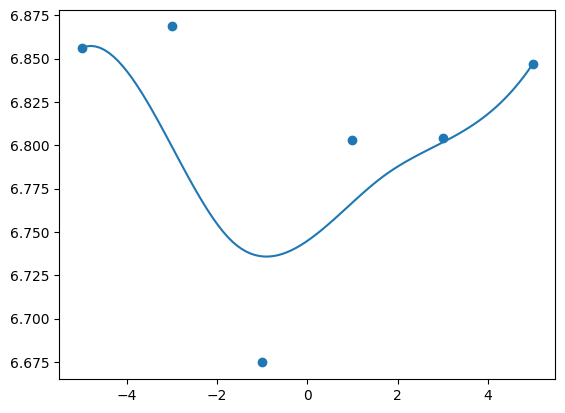

In [5]:
c = [6.8562, 6.8685, 6.6747, 6.8028, 6.8039, 6.8469]
k = 3


x = np.linspace(-5, 5, 100)
y = [F.bspline(i, c, (-5, 5), k) for i in x]

plt.scatter([i for i in np.linspace(-5, 5, len(c))], c) 
plt.plot(x, y)
plt.show()

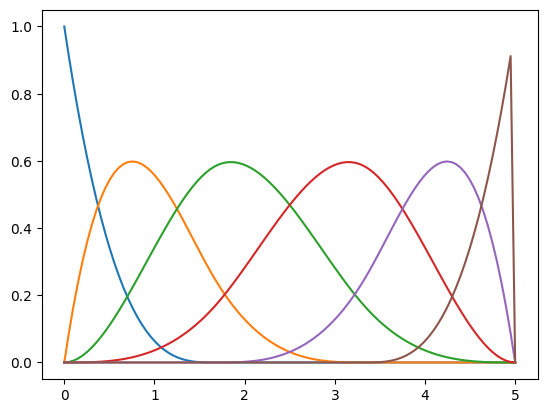

In [6]:
t = np.concatenate(([0] * k, np.linspace(0, len(c)-1, len(c)-k+1), [len(c)-1] * k))
x = np.linspace(0, len(c)-1 , 100)

for i in range(len(c)):
    y = [F.B(j, k, i, t) for j in x]
    plt.plot(x, y)

In [7]:
class Phi:
    def __init__(self, num_c, range_c, k):
        self.num_c = num_c
        self.range_c = range_c
        self.k = k
        self.c = torch.normal(0, 0.1, (num_c, ), requires_grad=True, device=device)
        self.wb = torch.randn(1, requires_grad=True, device=device)
        self.ws = torch.randn(1, requires_grad=True, device=device)
        
    def parameters(self):
        return [self.c, self.wb, self.ws]
    
    def __call__(self, x):
        return self.wb * F.bspline(x, self.c, self.range_c, self.k) + self.ws * F.silu(x)
    
    def plot(self):
        x = np.linspace(self.range_c[0], self.range_c[1], 100)
        y = [self(torch.tensor(i)).detach().cpu().numpy() for i in x]
        plt.plot(x, y)
        plt.scatter([i for i in np.linspace(self.range_c[0], self.range_c[1], self.num_c)], self.c.detach().cpu().numpy(), color='red')
        plt.show()

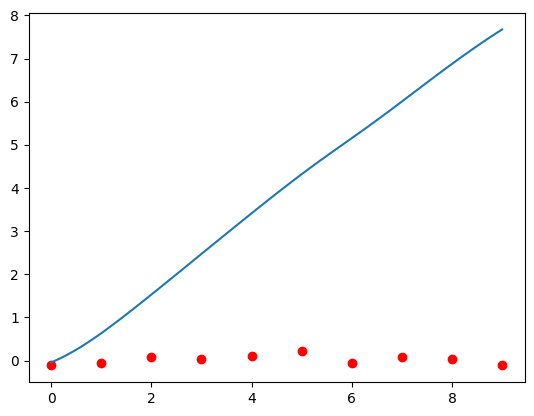

In [8]:
phi = Phi(10, (0, 9), 3)
phi.plot()

x = torch.tensor(5.0, dtype=torch.float32, requires_grad=True, device=device)
y = phi(x)

In [9]:
class Layer:
    def __init__(self, input_size, output_size, num_control_points, range_c, k):
        self.input_size = input_size
        self.output_size = output_size
        self.functions = [[Phi(num_control_points, range_c, k) for i in range(input_size)] for j in range(output_size)]
        
    def parameters(self):
        return [param for i in range(self.output_size) for j in range(self.input_size) for param in self.functions[i][j].parameters()]
    
    def forward(self, x):
        output = []
        for i in range(self.output_size):
            sum = 0
            for j in range(self.input_size):
                sum += self.functions[i][j](x[j])
            output.append(sum)
        return torch.stack(output)          
    
    def __call__(self, x):
        return self.forward(x)

In [10]:
class KAN(nn.Module):
    def __init__(self, input_size, layers, num_control_points, range_c, k):
        super(KAN, self).__init__()
        self.input_size = input_size
        layers = [input_size] + layers
        self.layers = [Layer(layers[i-1], layers[i], num_control_points, range_c, k) for i in range(1, len(layers))]
        
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]
    
    
    def forward(self, x):
        def single_forward(x):
            for layer in self.layers:
                x = layer(x)
            return x
        
        def batch_forward(x):
            return torch.stack([single_forward(i) for i in x]).squeeze(1)
        
        if len(x.shape) == 1:
            # x = x.clone().detach().requires_grad_(True)
            return single_forward(x)
        else:
            # x = x.clone().detach().requires_grad_(True)
            return batch_forward(x)
    
    
    def __call__(self, x):
        return self.forward(x)

In [11]:
def f(x, y):
    return f4(x, y)

def f1(x):
    return np.exp(x)

def f2(x):
    return np.exp(np.sin(x))

def f3(x, y):
    return x**2 + y**2

def f4(x, y):
    return np.sin(x) + np.cos(y)

In [12]:
x = np.linspace(-5, 5, 10)
y = np.linspace(-5, 5, 10)

X = [[x[i], y[j]] for i in range(len(x)) for j in range(len(y))]
X = np.array(X)
X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=True, device=device)
Y = torch.tensor(np.array([f(x, y) for x, y in X]), dtype=torch.float32).unsqueeze(1).to(device)

dataset = MakeDataset(X_tensor, Y)

In [13]:
kan = KAN(2, [1], 6, (-5, 5), 3).to(device)

x = torch.tensor([[5.0, 5,0]], dtype=torch.float32, requires_grad=True)
y = kan(x)

In [ ]:
# train the model
optimizer = torch.optim.Adam(kan.parameters(), lr=0.02)
data_loader = DataLoader(dataset, batch_size=10, shuffle=False)
for i in range(100):
    for idx, (x, y) in enumerate(data_loader):
        y_pred = kan(x)
        loss = F.mse(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 1 == 0:
            print(f'Epoch: {i}, Step: {idx}, Loss: {loss.item()}')
    

Epoch: 0, Step: 0, Loss: 5.287405014038086
Epoch: 0, Step: 1, Loss: 4.599822998046875
Epoch: 0, Step: 2, Loss: 2.132800340652466
Epoch: 0, Step: 3, Loss: 1.8088769912719727
Epoch: 0, Step: 4, Loss: 1.6182854175567627
Epoch: 0, Step: 5, Loss: 2.4178197383880615
Epoch: 0, Step: 6, Loss: 3.1940126419067383
Epoch: 0, Step: 7, Loss: 1.746475100517273
Epoch: 0, Step: 8, Loss: 1.339597225189209
Epoch: 0, Step: 9, Loss: 1.6757957935333252
Epoch: 1, Step: 0, Loss: 2.3819339275360107
Epoch: 1, Step: 1, Loss: 2.024536371231079
Epoch: 1, Step: 2, Loss: 0.8344632983207703
Epoch: 1, Step: 3, Loss: 1.3902781009674072
Epoch: 1, Step: 4, Loss: 0.9253635406494141
Epoch: 1, Step: 5, Loss: 0.842515766620636
Epoch: 1, Step: 6, Loss: 1.3213999271392822
Epoch: 1, Step: 7, Loss: 0.6012254357337952
Epoch: 1, Step: 8, Loss: 0.9471317529678345
Epoch: 1, Step: 9, Loss: 1.0793038606643677
Epoch: 2, Step: 0, Loss: 1.047363519668579
Epoch: 2, Step: 1, Loss: 0.9162346124649048
Epoch: 2, Step: 2, Loss: 0.4533464908599

In [ ]:
phi00 = kan.layers[0].functions[0][0]
phi01 = kan.layers[0].functions[0][1]

phi00.plot()
phi01.plot()

In [ ]:
# plot the result in 3d with plotly graph object
import plotly.graph_objects as go

x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)

# make the grid
X = [[x[i], y[j]] for i in range(len(x)) for j in range(len(y))]
X = np.array(X)
X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=True, device=device)
Y = torch.tensor(np.array([f(x, y) for x, y in X]), dtype=torch.float32).unsqueeze(1).to(device)

Y_pred = kan(X_tensor).detach().cpu().numpy()


In [ ]:
# scatter X and Y in 3d
fig = go.Figure(data=[
    go.Surface(x=x, y=y, z=Y.cpu().numpy().reshape(50, 50), name='real', colorscale='Reds'),
    go.Surface(x=x, y=y, z=Y_pred.reshape(50, 50), name='pred', colorscale='Blues')])

fig.show()